# Fldgen: Climate variable field generator

This workbook attempts to recreate the methods in `fldgen`, originally written in R.

Source: [JGCRI/fldgen](https://github.com/JGCRI/fldgen)

Data as `NETCDF` files downloaded along with the `fldgen` R package.

In [2]:
import sys
import os
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML, display # NOTE: will require ffmpeg installation
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import rioxarray
from shapely.geometry import mapping
from xeofs.xarray import EOF
from xarrayutils.utils import linear_trend, xr_linregress
import gc
import collections
import statsmodels.api as sm
import scipy
import rpy2
from sklearn.linear_model import LinearRegression

In [3]:
# Define project repo path
inDirName = '/Users/smurugan9/research/aislens/aislens_emulation/'

# DATA FILE PATHS

# Data containing regridded flux and SSH for 150 years
regriddedFluxSSH_filepath = 'data/interim/RegriddedFluxSSH.nc'

# File contains all defined ice shelves
iceShelvesShape_filepath = 'data/interim/iceShelves.geojson'

# Folder for output figures
figures_folderpath = 'reports/figures/' 

interim_data_folder = 'data/interim/'
flux_dedrafted_data_path = 'dedrafted_flux_IMBIE/'
randomized_realizations_path = 'randomized_realizations/'
flux_dedrafted_iceshelves_data_path = 'iceshelves_dedrafted_flux/'

## Input Datasets

Temperature for `fldgen` v1.0, Temperature and Precipitation for `fldgen` v2.0 (not incorporated yet), for inter-variable correlations of the variability.

In [119]:
infileTpath = "/Users/smurugan9/Library/R/arm64/4.1/library/fldgen/extdata/tas_annual_esm_rcp_r2i1p1_2006-2100.nc"
T = xr.open_dataset(
    "/Users/smurugan9/Library/R/arm64/4.1/library/fldgen/extdata/tas_annual_esm_rcp_r2i1p1_2006-2100.nc")
P = xr.open_dataset(
    "/Users/smurugan9/Library/R/arm64/4.1/library/fldgen/extdata/pr_annual_esm_rcp_r2i1p1_2006-2100.nc")
tann = xr.open_dataset("/Users/smurugan9/Library/R/arm64/4.1/library/fldgen/extdata/tann1.nc")

In [179]:
# Legacy method, not accurate (dimension indexing not right)

"""
tas = tann.tas.stack(z=("lat","lon"))

# Define global operator as area factor based on colatitude
tgop = np.repeat(np.cos(tann.lat*np.pi/180),len(tann.lon))
tgop = tgop/sum(tgop.values)

"""

In [333]:
ngen = 4             # number of fields to generate
exfld = 20           # example field to plot from the time series
np.random.seed(8675309) # Set RNG seed so results will be reproducible

## Pre-process 3D Grid

This section attempts to recreate the pre-processing (area weighted normalization?) in the `fldgen` paper, to ensure only the residuals of the mean global temperature are used in the EOF decomposition.

#### ISSUES: 
The EOF modes are reversed (-1 x) values of those shown in the [fldgen paper: Fig. 6](https://gmd.copernicus.org/articles/12/1477/2019/#&gid=1&pid=1).

In [324]:
tas = tann.tas
# Define global operator as area factor based on colatitude

tgop = np.cos(np.radians(tann.lat.values))
tgoprep = np.repeat(tgop[:,np.newaxis], 288, axis=1)
tgoprep = tgoprep.transpose()
tgoprep = tgoprep/sum(sum(tgoprep))

tgoprepxr = xr.DataArray(tgoprep,
                         dims=tann.tas[0].transpose().dims, 
                         coords=tann.tas[0].transpose().coords)

In [331]:
tgav = tas @ tgoprepxr
xrtgav = xr.DataArray(tgav, dims='time')

In [334]:
xreg = xr_linregress(xrtgav,tas,dim='time')
b = xreg.intercept
w = xreg.slope

In [337]:
residual = tas -(xrtgav*w + b)
r = residual # This is akin to the internal variability. 

In the Antarctic problem, this step might not be necessary, since the linear trend, regression and melt-depth dependency are already accounted for
flux_clean would be sufficient.
However, area weighting remains to be tested.

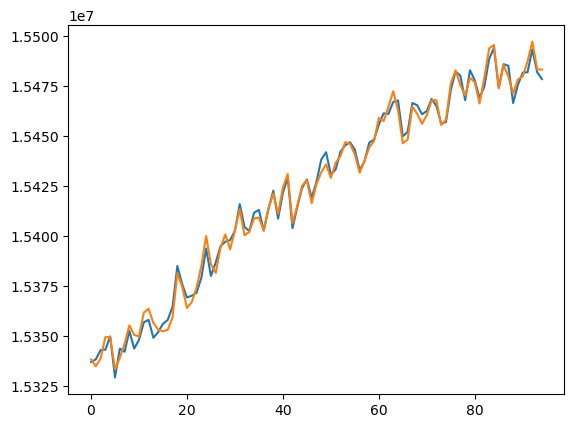

In [442]:
#plt.plot(r.sum(['lat','lon']))
plt.plot(tas.sum(['lat','lon']))
plt.plot((xrtgav*w + b).sum(['lat','lon']))
#plt.plot(resids.sum(['lat','lon']))
#plt.plot(r.sum(['lat','lon']))

In [401]:
xh0 = tgoprepxr

In [413]:
xh0 = xh0/np.sqrt(xh0 @ xh0)
#proj0 = r.values.transpose()*xh0
proj0 = r*xh0
#resids = r.transpose() - proj0 @ xh0
resids = r - proj0*xh0
#resids = resids.unstack()

In [430]:
prj = r @ (xh0/np.sqrt(xh0 @ xh0)).transpose()
resids = r - prj @ xh0

## PCA Decomposition

In [432]:
%%time
model = EOF(resids)
model.solve()
teofs = model.eofs()
tpcs = model.pcs()

CPU times: user 10.3 s, sys: 981 ms, total: 11.3 s
Wall time: 1.71 s


In [433]:
abs_max = np.amax(teofs,axis=(0,1)) # np.max(teofs) #np.amax(np.abs(teofs))
eof_norm = teofs*1.0/abs_max

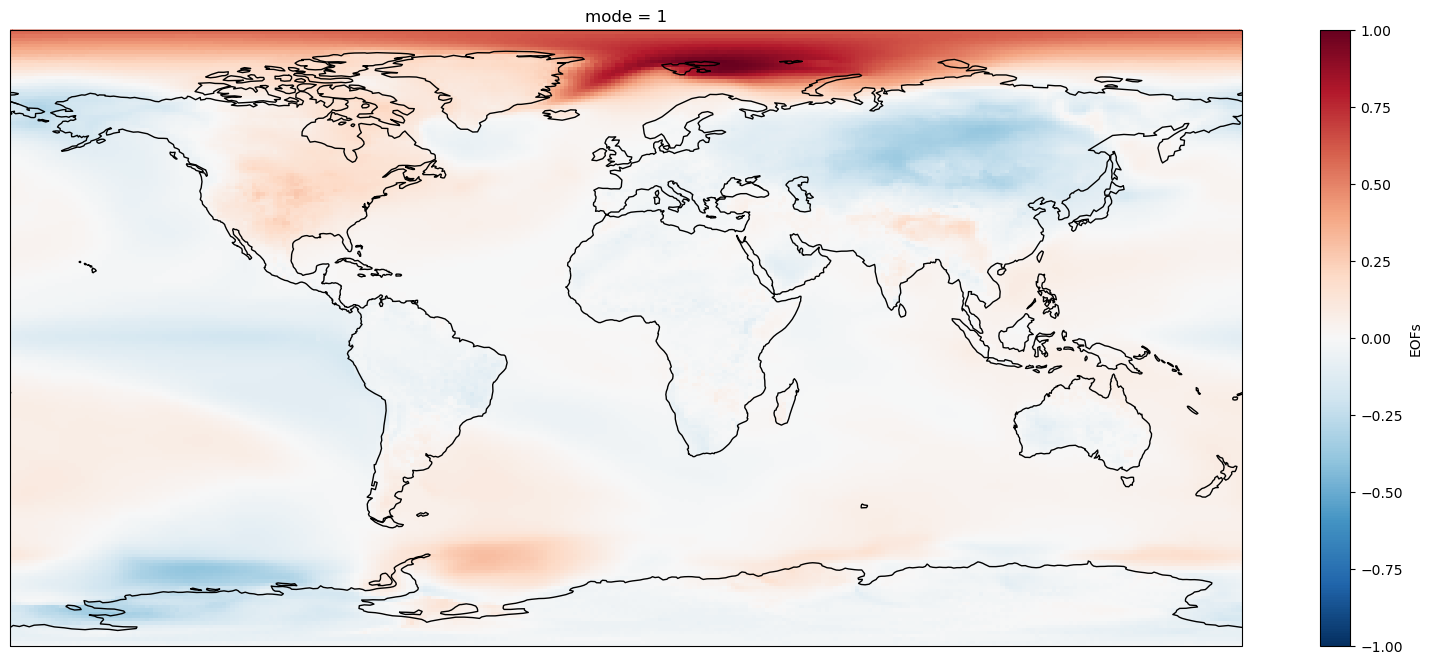

In [435]:
plt.figure(figsize=(20,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
eof_norm[:,:,0].plot()

<Figure size 1500x1600 with 0 Axes>

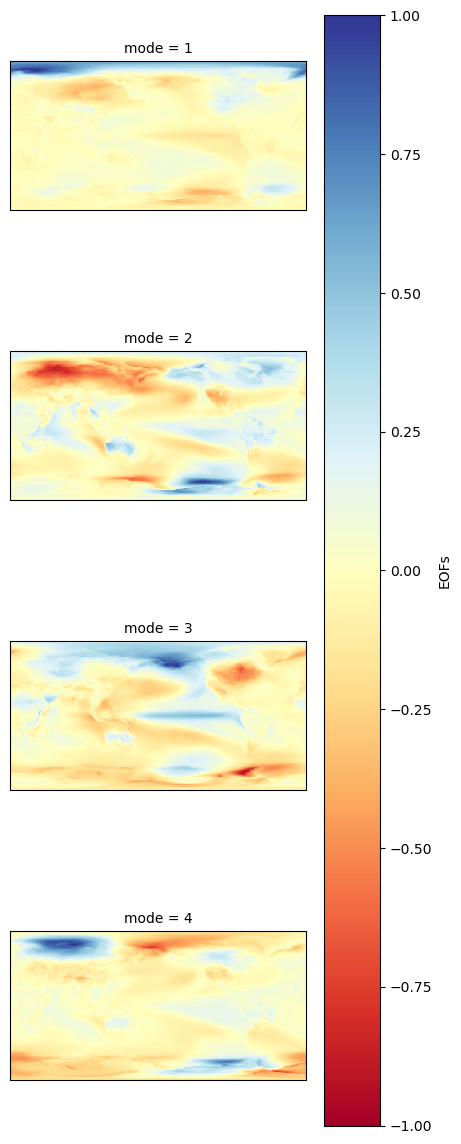

In [366]:
plt.figure(figsize=(15,16))
#ax = plt.subplots(2,3,projection=ccrs.PlateCarree())

#ax.coastlines()
fg = eof_norm[:,:,0:4].plot(col="mode",
                            col_wrap=1,
                            cmap='RdYlBu',
                            subplot_kws=dict(projection=ccrs.SouthPolarStereo()))

In [ ]:
teigs = model.explained_variance_ratio()
teigs_frac = teigs*100/sum(teigs)
plt.plot(teigs_frac[:])

## Fourier Phase Randomization

In [ ]:
%%time
##############################
# FOURIER PHASE RANDOMIZATION 
##############################

# Define number of random Fourier realizations
n_realizations = 25
t_length = tpcs.shape[0]

# fluxpcs[:,i] when using PCA outputs
new_fl = np.empty((n_realizations,tpcs.shape[0],tpcs.shape[1]))

# Time limits for plotting
t1 = 0
tf = int(t_length/2)

for i in range(n_realizations):
    for m in range(model.n_modes):
        fl = tpcs[:,m] # fluxpcs[:,i] when using PCA outputs
        print(fl.shape)
        fl_fourier = np.fft.rfft(fl)
        print(fl_fourier.shape)
        random_phases = np.exp(np.random.uniform(0,2*np.pi,int(len(fl)/2+1))*1.0j)
        print(random_phases.shape)
        fl_fourier_new = fl_fourier*random_phases
        print(fl_fourier_new.shape)
        new_fl[i,:,m] = np.fft.irfft(fl_fourier_new,n=95)
        print(new_fl.shape)
        print('calculated ifft for realization {}'.format(i))
        # plt.plot(new_fl[i,t1:tf],'b', linewidth=0.15) # PLOT LATER! Plotting here adds significant computation time

In [ ]:
# ======================================================
# PHASE RANDOMIZED TIME SERIES PLOTS (PCs) =============
# ======================================================

plt.figure(figsize=(25, 8), dpi=80)

for i in range(n_realizations):
    plt.plot(new_fl[i,t1:tf,1],'b', linewidth=0.15)

plt.plot(new_fl[0,t1:tf,1],'b', linewidth=1, label='Randomized Output')
plt.plot(new_fl[1,t1:tf,1],'b', linewidth=1)
plt.plot(new_fl[0,t1:tf,1],'b', linewidth=1)
plt.plot(tpcs[t1:tf,1],'k', linewidth=3, label='MPAS Output')
plt.title('Deseasonalized and Detrended Flux (Years: {:.1f} - {:.1f})'.
          format((t1)/12,(tf)/12))
plt.ylabel('landIceFreshwaterFlux')
plt.legend()

## Randomized Data Reconstruction

In [ ]:
from scipy import signal

In [ ]:
plt.figure(figsize=(25,8))
for i in range(5):
    plt.psd(tpcs[:,i]);
    #f, Pxx = signal.welch(tpcs[:,i])
    #plt.semilogy(f, Pxx)

In [ ]:
%%time
### Reconstruct field: code optimized
# Store the input data in an instance variable.
if res.ndim < 2:
    raise ValueError('the input data set must be at least two dimensional')
_data = res.to_numpy().copy()
# Check if the input is a masked array. If so fill it with NaN.
try:
    _data = _data.filled(fill_value=np.nan)
    _filled = True
except AttributeError:
    _filled = False
# Store information about the shape/size of the input data.
_records = _data.shape[0]
_originalshape = _data.shape[1:]
channels = np.product(_originalshape)
# Remove the time mean of the input data unless explicitly told
# not to by the "center" argument.
# Reshape to two dimensions (time, space) creating the design matrix.
_data = _data.reshape([_records, channels])
# Find the indices of values that are not missing in one row. All the
# rows will have missing values in the same places provided the
# array was centered. If it wasn't then it is possible that some
# missing values will be missed and the singular value decomposition
# will produce not a number for everything.
if not _valid_nan(_data):
    raise ValueError('missing values detected in different '
                     'locations at different times')
nonMissingIndex = np.where(np.logical_not(np.isnan(_data[0])))[0]
# Remove missing values from the design matrix.
dataNoMissing = _data[:, nonMissingIndex]
if dataNoMissing.size == 0:
    raise ValueError('all input data is missing')
# Compute the singular value decomposition of the design matrix.
try:
    A, Lh, E = np.linalg.svd(dataNoMissing, full_matrices=False)
except (np.linalg.LinAlgError, ValueError):
    raise ValueError('error encountered in SVD, check that missing '
                     'values are in the same places at each time and '
                     'that all the values are not missing')
# Singular values are the square-root of the eigenvalues of the
# covariance matrix. Construct the eigenvalues appropriately and
# normalize by N-ddof where N is the number of observations. This
# corresponds to the eigenvalues of the normalized covariance matrix.
_ddof = 1 # defaults to 1
normfactor = float(_records - _ddof)
_L = Lh * Lh / normfactor
# Store the number of eigenvalues (and hence EOFs) that were actually
# computed.
neofs = len(_L)
# Re-introduce missing values into the eigenvectors in the same places
# as they exist in the input maps. Create an array of not-a-numbers
# and then introduce data values where required. We have to use the
# astype method to ensure the eigenvectors are the same type as the
# input dataset since multiplication by np.NaN will promote to 64-bit.
_flatE = np.ones([neofs, channels],
                      dtype=_data.dtype) * np.NaN
_flatE = _flatE.astype(_data.dtype)
_flatE[:, nonMissingIndex] = E
# Remove the scaling on the principal component time-series that is
# implicitily introduced by using SVD instead of eigen-decomposition.
# The PCs may be re-scaled later if required.
#_P = A * Lh

In [ ]:
%%time

####################
# EOF RECONSTRUCTION 
####################

for i in range(n_realizations):
    tpcs_new = xr.DataArray(new_fl[i], 
                               coords=tpcs.coords, 
                               dims = tpcs.dims, 
                               attrs=tpcs.attrs)
    _P = tpcs_new.to_numpy()
    if isinstance(neofs, collections.abc.Iterable):
        modes = [m - 1 for m in neofs]
    else:
        modes = slice(0, neofs)
    # Project principal components onto the EOFs to compute the
    # reconstructed field.
    print('Calculating data for realization #{}'.format(i))
    rval = np.dot(_P[:, modes], _flatE[modes])
    # Reshape the reconstructed field so it has the same shape as the
    # input data set.
    rval = rval.reshape((_records,) + _originalshape)

    # Return the reconstructed field.
    if _filled:
        rval = ma.array(rval, mask=np.where(np.isnan(rval), True, False))
    
    reconstr_full = xr.DataArray(rval, 
                                 dims = res.dims, 
                                 coords = res.coords, 
                                 attrs = res.attrs)
    reconstr_full = reconstr_full.rename('timeMonthly_avg_landIceFreshwaterFlux')
    print('Reconstructed data for realization #{}'.format(i))    
    # Save reconstructed realization
    reconstr_full.to_netcdf(inDirName+
                            interim_data_folder+
                            randomized_realizations_path+
                            'Resid_randomized_temp_n_{}'.
                            format(i))
    print('Saved datafile for realization #{}'.format(i))
    del tpcs_new, _P, modes, rval, reconstr_full 
    print('deleting interim variables')
    gc.collect()

In [ ]:
# Select randomized data realization to compare
tnew = xr.open_dataset(inDirName+
                                interim_data_folder+
                                randomized_realizations_path+
                                'Resid_randomized_temp_n_{}'.
                                format(0))

In [ ]:
tnew = tnew.timeMonthly_avg_landIceFreshwaterFlux

In [ ]:
def f_test(x, y):
    x = np.array(x)
    y = np.array(y)
    f = np.var(x, ddof=1)/np.var(y, ddof=1) #calculate F test statistic 
    dfn = x.size-1 #define degrees of freedom numerator 
    dfd = y.size-1 #define degrees of freedom denominator 
    p = 1-scipy.stats.f.cdf(f, dfn, dfd) #find p-value of F test statistic 
    return f, p

In [ ]:
f_test(res, tnew)

In [ ]:
tnew.plot()

In [ ]:
lev_stat, lev_p = scipy.stats.levene(res1d, tnew1d)

In [ ]:
res1d = res.stack(z=('time','lat','lon'))
tnew1d = tnew.stack(z=('time','lat','lon'))

In [ ]:
print(lev_stat, lev_p)

In [ ]:
from scipy.stats import beta

In [ ]:
scipy.stats.pearsonr(res1d,tnew1d)

In [ ]:
plt.figure(figsize=(25,8))
plt.psd(orig_basin_ts,label='Original', color='k')
plt.psd(rec_basin_ts,label='Randomized', color = 'b')
plt.title('PSD of original and reconstructed data: {}'.format(icems.name.values[basin]))
plt.legend()


In [ ]:

fig, axs = plt.subplots(4,4,figsize=(30,16))
axs=axs.ravel()

for mode_m in range(0,16):
    for i in range(0,15):
        axs[mode_m].psd(new_fl[i,:,mode_m],color='b', linewidth=0.5)
    axs[mode_m].psd(new_fl[0,:,mode_m],color='b', linewidth=0.25,label='Randomized')
    axs[mode_m].psd(tpcs[:,mode_m],color='k', linewidth=1.5,label='Original')
    axs[mode_m].set_title('PSD of PC for mode {}'.format(mode_m))
plt.legend()